# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 3 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [127]:
# Change here using YOUR first and last names
fn1 = "Xingyuan"
ln1 = "Xue"
fn2 = "Ling"
ln2 = "Jin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_xue_xingyuan_and_jin_ling.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [128]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce a class that will be used for the solvers.

In [130]:
from scipy.linalg import svd


class LinReg(object):
    """A class for the least-squares regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda

    def grad(self, x):
        return self.A.T.dot(self.A.dot(x) - self.b) / self.n + self.lbda * x

    def loss(self, x):
        return norm(self.A.dot(x) - self.b) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.

    def grad_i(self, i, x):
        a_i = self.A[i]
        return (a_i.dot(x) - self.b[i]) * a_i + self.lbda * x

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / self.n + self.lbda

In [131]:
class LogReg(object):
    """A class for the logistic regression with L2/Ridge penalization"""

    def __init__(self, A, b, lbda):
        self.A = A
        self.b = b
        self.n, self.d = A.shape
        self.lbda = lbda
    
    def grad(self, x):
        bAx = self.b * np.dot(self.A, x)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.A.T, self.b * temp) / self.n + self.lbda * x
        return grad

    def loss(self, x):
        bAx = self.b * np.dot(self.A, x)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(x) ** 2 / 2.
    
    def grad_i(self, i, x):
        grad = - self.A[i] * self.b[i] / (1. + np.exp(self.b[i] * np.dot(self.A[i], x)))
        grad += self.lbda * x
        return grad

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [132]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """
    Simulation for the least-squares problem

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [133]:
def simu_logreg(x, n, std=1., corr=0.5):
    """
    Simulation for the logistic regression problem
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [232]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

#_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.7)
#_A_1, _b_1 = simu_linreg(x_model_truth, n, std=1., corr=0.1)
_A_1, _b_1 = simu_logreg(x_model_truth, n, std=1., corr=0.1)
_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

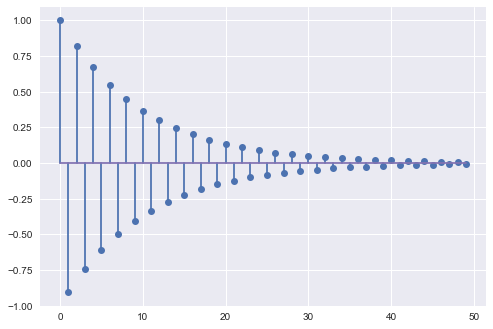

In [183]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [184]:
from scipy.optimize import check_grad
lbda = 1. / n ** (0.5) # High regularization
model = LinReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

3.7364254247213682e-06

In [185]:
lbda = 1. / n ** (0.5)
model = LogReg(_A, _b, lbda)

# Check that the gradient and the loss numerically match
check_grad(model.loss, model.grad, np.random.randn(d))

2.6859023295119348e-07

### Choice of the model

In [186]:
llbda = 1. / n # Low regularization

In [233]:
#model = LinReg(_A, _b, lbda)
#model_llbda = LinReg(_A, _b, llbda)
#model_c1 = LinReg(_A_1, _b_1, lbda)
model = LogReg(_A, _b, lbda)
model_llbda = LogReg(_A, _b, llbda) # Model with low regularization
model_c1 = LogReg(_A_1, _b_1, lbda)

### Compute the theoretical step-size for FISTA

In [188]:
from scipy.linalg import svd

#step = 1. / model.lipschitz_constant()
step = 1. / model_llbda.lipschitz_constant()

print("step = %s" % step)

step = 0.181132554588


### Get a very precise minimum to compute distances to minimum
2 minimum are concerned under these conditions ($corr=0.7$):

- $\lambda = 1/\sqrt{n}$
- $\lambda = 1/n$

1 minimum of low correlation ($corr=0.1$, $\lambda = 1/\sqrt{n}$)


In [234]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, pgtol=1e-30, factr=1e-30)
print(f_min)

0.51713422992


In [235]:
# True minimum and minimizer of moel with low regularization
x_init = np.zeros(d)
x_min_l, f_min_l, _ = fmin_l_bfgs_b(model_llbda.loss, x_init, model_llbda.grad, pgtol=1e-30, factr=1e-30)
print(f_min_l)

0.464408360615


In [236]:
x_init = np.zeros(d)
x_min_c1, f_min_c1, _ = fmin_l_bfgs_b(model_c1.loss, x_init, model_c1.grad, pgtol=1e-30, factr=1e-30)
print(f_min_c1)

0.363225830706


<a id='batch'></a> 

## 3. Deterministic methods (ISTA, FISTA, BFGS)

Before implementing GD, ISTA or FISTA we provide a simple function to be called after each iteration to gather and display a few metrics about the current minimization process.

In [237]:
import time

def inspector(loss_fun, x_real, f_real, verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    timing = [] 
    def inspector_cl(xk):
        obj = loss_fun(xk) - f_real
        err = norm(xk - x_real)
        tim = time.time() - t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [238]:
# Number of iterations
n_iter = 50

### ISTA

We recall that an iteration of ISTA (actually a batch gradient here) writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the ISTA solver in the cell below

In [239]:
def ista(x_init, grad, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    x = x_init.copy()
    
    for _ in range(n_iter):
        
        ### TODO
        x = x - step*grad(x)
        # step =
        # grad(x) = 
        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)

    return x

In [240]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_ista = ista(x_init, model.grad, n_iter, step, callback=ista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.48e-01 | 2.56e+00 | 0.0000e+00
      10 | 6.58e-02 | 1.83e+00 | 2.2137e-02
      20 | 3.43e-02 | 1.36e+00 | 5.3402e-02
      30 | 1.89e-02 | 1.03e+00 | 8.4647e-02
      40 | 1.08e-02 | 7.83e-01 | 1.1691e-01


In [241]:
step_l = 1. / model_llbda.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_ista_l = ista(x_init, model_llbda.grad, n_iter, step_l, callback=ista_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 2.00e-01 | 4.05e+00 | 0.0000e+00
      10 | 1.12e-01 | 3.29e+00 | 3.1275e-02
      20 | 7.22e-02 | 2.76e+00 | 4.6906e-02
      30 | 4.94e-02 | 2.35e+00 | 7.8165e-02
      40 | 3.51e-02 | 2.03e+00 | 1.1597e-01


In [242]:
step_c1 = 1. / model_c1.lipschitz_constant()
x_init = np.zeros(d)
ista_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_ista_c1 = ista(x_init, model_c1.grad, n_iter, step_c1, callback=ista_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 1.05e-01 | 1.83e+00 | 1.5604e-02
      10 | 1.97e-03 | 2.99e-01 | 3.1235e-02
      20 | 1.14e-04 | 7.34e-02 | 6.2481e-02
      30 | 7.56e-06 | 1.90e-02 | 8.4623e-02
      40 | 5.18e-07 | 4.98e-03 | 1.1588e-01


### FISTA

We recall that an iteration of FISTA (actually an accelerated batch gradient here) writes

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the FISTA solver in the cell below

In [243]:
def fista(x_init, grad, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        
        ### TODO
        t_new = (1 + np.sqrt(1 + 4.*t**2)) / 2
        x_new = y - step*grad(y)
        y[:] = x_new + (t - 1) / t_new*(x_new - x)
        t = t_new
        x[:] = x_new.copy()

        ### END TODO

        # Update metrics after each iteration.
        if callback is not None: 
            callback(x)
    return x

In [244]:
step = 1. / model.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_fista = fista(x_init, model.grad, n_iter, step, callback=fista_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.48e-01 | 2.56e+00 | 0.0000e+00
      10 | 2.58e-02 | 1.19e+00 | 3.7266e-02
      20 | 8.02e-05 | 6.38e-02 | 5.3399e-02
      30 | 7.80e-04 | 2.20e-01 | 8.4659e-02
      40 | 2.37e-05 | 3.76e-02 | 1.1590e-01


In [245]:
step_l = 1. / model_llbda.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_fista_l = fista(x_init, model_llbda.grad, n_iter, step_l, callback=fista_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 2.00e-01 | 4.05e+00 | 0.0000e+00
      10 | 6.14e-02 | 2.58e+00 | 1.5634e-02
      20 | 7.67e-03 | 1.02e+00 | 4.6885e-02
      30 | 2.40e-05 | 5.55e-02 | 7.8151e-02
      40 | 6.49e-04 | 3.22e-01 | 1.0027e-01


In [246]:
step_c1 = 1. / model_c1.lipschitz_constant()
x_init = np.zeros(d)
fista_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_fista_c1 = fista(x_init, model_c1.grad, n_iter, step_c1, callback=fista_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 1.05e-01 | 1.83e+00 | 1.5633e-02
      10 | 1.89e-04 | 9.60e-02 | 4.6894e-02
      20 | 1.34e-05 | 2.53e-02 | 6.2508e-02
      30 | 1.22e-06 | 7.67e-03 | 1.0027e-01
      40 | 9.54e-08 | 2.14e-03 | 1.1590e-01


### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s conjuguate gradient solver.

In [247]:
# Conjugate gradient descent
from scipy.optimize import fmin_cg

x_init = np.zeros(d)
cg_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_cg = fmin_cg(model.loss, x_init, model.grad, maxiter=n_iter, callback=cg_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.30e-01 | 2.40e+00 | 1.5632e-02
      10 | 4.63e-05 | 3.69e-02 | 8.3154e-02
      20 | 5.15e-08 | 1.22e-03 | 1.3154e-01
Optimization terminated successfully.
         Current function value: 0.517134
         Iterations: 26
         Function evaluations: 53
         Gradient evaluations: 53


In [248]:
x_init = np.zeros(d)
cg_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_cg_l = fmin_cg(model_llbda.loss, x_init, model_llbda.grad, maxiter=n_iter, callback=cg_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 1.82e-01 | 3.88e+00 | 1.5633e-02
      10 | 1.75e-04 | 8.62e-02 | 6.9031e-02
      20 | 2.90e-07 | 5.39e-03 | 1.4767e-01
      30 | 2.98e-09 | 4.02e-04 | 1.8493e-01
Optimization terminated successfully.
         Current function value: 0.464408
         Iterations: 32
         Function evaluations: 65
         Gradient evaluations: 65


In [249]:
x_init = np.zeros(d)
cg_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_cg_c1 = fmin_cg(model_c1.loss, x_init, model_c1.grad, maxiter=n_iter, callback=cg_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 3.76e-02 | 1.18e+00 | 1.5647e-02
Optimization terminated successfully.
         Current function value: 0.363226
         Iterations: 10
         Function evaluations: 26
         Gradient evaluations: 26


### scipy.optimize's BFGS

Let's compare with ``scipy.optimize``'s BFGS solver

In [250]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
bfgs_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_bfgs, _, _ = fmin_l_bfgs_b(model.loss, x_init, model.grad, maxiter=n_iter, callback=bfgs_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.30e-01 | 2.39e+00 | 1.5584e-02
      10 | 7.76e-05 | 4.92e-02 | 5.3349e-02
      20 | 1.73e-08 | 7.41e-04 | 1.0023e-01


In [251]:
x_init = np.zeros(d)
bfgs_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_bfgs_l, _, _ = fmin_l_bfgs_b(model_llbda.loss, x_init, model_llbda.grad, maxiter=n_iter, callback=bfgs_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 1.82e-01 | 3.88e+00 | 0.0000e+00
      10 | 2.86e-04 | 1.19e-01 | 4.6886e-02
      20 | 9.95e-08 | 2.17e-03 | 1.0028e-01


In [252]:
x_init = np.zeros(d)
bfgs_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_bfgs_c1, _, _ = fmin_l_bfgs_b(model_c1.loss, x_init, model_c1.grad, maxiter=n_iter, callback=bfgs_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 1.03e-01 | 1.81e+00 | 1.5627e-02


### A first numerical comparison of deterministic solvers

### Logistic Regression

In [1]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CD", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

NameError: name 'plt' is not defined

### Linear Regression

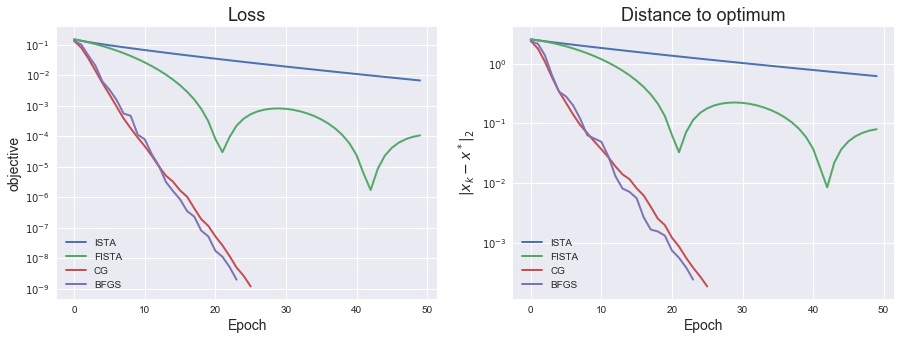

In [254]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

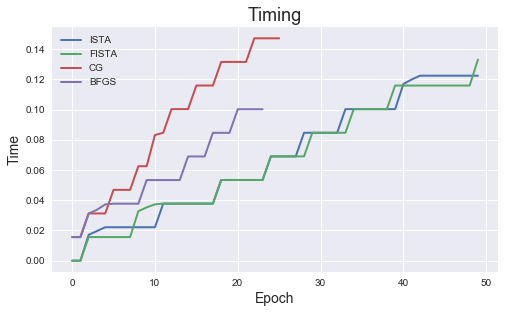

In [255]:
plt.figure(figsize=(8, 4.5))

plt.subplot(1, 1, 1)

inspectors = [ista_inspector, fista_inspector, cg_inspector, bfgs_inspector]

solvers = ["ISTA", "FISTA", "CG", "BFGS"]

for insp in inspectors:
    plt.plot(insp.timing, lw=2)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)

plt.legend(solvers)

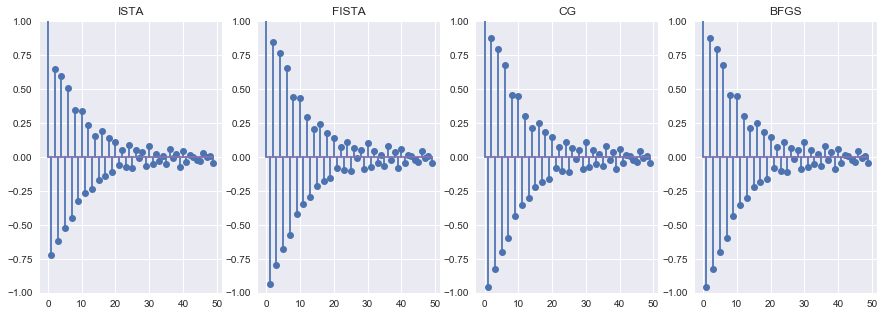

In [256]:
plt.figure(figsize=(15, 5))

xs = [x_ista, x_fista, x_cg, x_bfgs]

for i, name, x in zip(range(1, 5), solvers, xs):
    plt.subplot(1, 4, i)
    plt.stem(x)
    plt.ylim([-1, 1])
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about FISTA? is it suprising ?

*ANSWERS*:

*QUESTION 1*

### Case 1: Logistic Regression

- In terms of convergence performance, $BFGS>CG>FISTA>ISTA$.
- In terms of computation speed, $CG<BFGS<FISTA<ISTA$.

### Case 2: Linear Regression
- In terms of convergence performance, we have: $BFGS\sim CG>FISTA>ISTA$. The performances of $CG$ and $BFGS$ are about the same as in this case this is a quadratic problem.  
- In terms of computation speed, we have: $CG<BFGS<FISTA<ISTA$.

*QUESTION 2*

- The FISTA **bounds** during the convergence. It is not surprising. 
- The FISTA does not always go along the locally optimal direction. It has **weighted memory about the past** and the further the step is from the current step, the lighter this memory is weighted. Each time, it first updates its accumulated memory and goes along the gradient calculated with its accumulated memory. 
- This kind of search can sometimes leads to **errors** and thus the curves for distances to "true values" of loss and minimizer do **not decrease** all the time. 
- However, as the memory of wrong steps before fades away as the algorithm progresses, the algorithm can move back to the correct minimization path little by little and thus the distances of loss and minimizer can **decrease again** and decrease in general. 

<a id='stoc'></a> 
## 4. Stochastic methods

In [257]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)  

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [258]:
def sgd(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step / np.sqrt(n_iter + 1)*grad_i(i, x)
        

        ### END TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [259]:
step0 = 0.2
x_init = np.zeros(d)
sgd_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_sgd = sgd(x_init, iis, model.grad_i, n * n_iter, step=step0, callback=sgd_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.76e-01 | 2.66e+00 | 0.0000e+00
      10 | 1.29e-02 | 8.37e-01 | 2.1276e+00
      20 | 1.79e-03 | 3.10e-01 | 4.2484e+00
      30 | 1.04e-03 | 1.42e-01 | 6.2378e+00
      40 | 5.03e-04 | 8.57e-02 | 8.3128e+00


In [260]:
x_init = np.zeros(d)
sgd_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_sgd_l = sgd(x_init, iis, model_llbda.grad_i, n * n_iter, step=step0, callback=sgd_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 2.29e-01 | 4.15e+00 | 0.0000e+00
      10 | 3.87e-02 | 2.11e+00 | 2.1684e+00
      20 | 1.24e-02 | 1.26e+00 | 4.2272e+00
      30 | 5.48e-03 | 8.18e-01 | 6.4078e+00
      40 | 2.47e-03 | 5.45e-01 | 8.6295e+00


In [261]:
x_init = np.zeros(d)
sgd_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_sgd_c1 = sgd(x_init, iis, model_c1.grad_i, n * n_iter, step=step0, callback=sgd_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 3.30e-01 | 2.81e+00 | 0.0000e+00
      10 | 5.47e-03 | 4.80e-01 | 2.1055e+00
      20 | 7.96e-04 | 1.56e-01 | 4.2641e+00
      30 | 3.45e-04 | 7.66e-02 | 6.3695e+00
      40 | 2.44e-04 | 6.21e-02 | 8.5217e+00


### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [262]:
def sag(x_init, iis, grad_i, n_iter=100, step=1., callback=None):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    y = np.zeros(d)
    old_grad = np.zeros(d)

    gradient_memory = np.array([grad_i(j, x) for j in range(n)])
    y = np.sum(gradient_memory, axis=0) / n
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        old_grad[:] = gradient_memory[i][:]
        gradient_memory[i][:] = grad_i(i, x)[:]
        y += (gradient_memory[i] - old_grad) / n 
        x -= step*y

        ### END OF TODO
        
        # Update metrics after each iteration.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [263]:
max_squared_sum = np.max(np.sum(model.A ** 2, axis=1))

if isinstance(model, LogReg):
    step = 4.0 / (max_squared_sum + 4.0 * model.lbda)
else:
    step = 1.0 / (max_squared_sum + model.lbda)

x_init = np.zeros(d)
sag_inspector = inspector(model.loss, x_min, f_min, verbose=True)
x_sag = sag(x_init, iis, model.grad_i, n * n_iter, step, callback=sag_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.75e-01 | 2.66e+00 | 1.3151e-01
      10 | 4.48e-03 | 1.90e-01 | 2.9769e+00
      20 | 7.97e-06 | 1.02e-02 | 6.0469e+00
      30 | 3.16e-08 | 6.07e-04 | 8.8545e+00
      40 | 1.57e-10 | 3.44e-05 | 1.1646e+01


In [264]:
max_squared_sum_l = np.max(np.sum(model_llbda.A ** 2, axis=1))

if isinstance(model_llbda, LogReg):
    step_l = 4.0 / (max_squared_sum_l + 4.0 * model_llbda.lbda)
else:
    step_l = 1.0 / (max_squared_sum_l + model_llbda.lbda)

x_init = np.zeros(d)
sag_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)
x_sag_l = sag(x_init, iis, model_llbda.grad_i, n * n_iter, step_l, callback=sag_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 2.28e-01 | 4.14e+00 | 1.3152e-01
      10 | 3.42e-03 | 4.20e-01 | 3.0382e+00
      20 | 1.43e-05 | 1.19e-02 | 5.8455e+00
      30 | 4.84e-08 | 7.29e-04 | 8.8041e+00
      40 | 1.25e-10 | 4.30e-05 | 1.1611e+01


In [265]:
max_squared_sum_c1 = np.max(np.sum(model_c1.A ** 2, axis=1))

if isinstance(model_c1, LogReg):
    step_c1 = 4.0 / (max_squared_sum_c1 + 4.0 * model_c1.lbda)
else:
    step_c1 = 1.0 / (max_squared_sum_c1 + model_c1.lbda)

x_init = np.zeros(d)
sag_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)
x_sag_c1 = sag(x_init, iis, model_c1.grad_i, n * n_iter, step_c1, callback=sag_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 3.26e-01 | 2.80e+00 | 1.3157e-01
      10 | 8.62e-03 | 3.54e-01 | 2.8697e+00
      20 | 4.76e-05 | 2.57e-02 | 5.5142e+00
      30 | 2.30e-07 | 1.78e-03 | 8.2682e+00
      40 | 2.88e-09 | 2.01e-04 | 1.0918e+01


### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [266]:
def svrg(x_init, iis, grad, grad_i, n_iter, step, callback=None):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    
    for idx in range(n_iter):
        
        if idx % n == 0:
            x_old = x.copy()
            grad_old = grad(x_old).copy()
        ### TODO
        i = iis[idx]
        grad_x = grad_i(i, x) - grad_i(i, x_old) + grad_old
        x -= step*grad_x
        
        ### END TODO        
        
        # Update metrics after each full pass on data.
        if callback is not None and idx % n == 0:
            callback(x)
    return x

In [267]:
# step = 0.1 / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector = inspector(model.loss, x_min, f_min, verbose=True)    
x_svrg = svrg(x_init, iis, model.grad, model.grad_i, n * n_iter, step, callback=svrg_inspector)

   it    |   obj    |   err    |   time  
       0 | 1.75e-01 | 2.66e+00 | 0.0000e+00
      10 | 6.11e-10 | 7.65e-05 | 3.2365e+00
      20 | 0.00e+00 | 3.86e-08 | 6.5454e+00
      30 | 0.00e+00 | 3.96e-08 | 9.8388e+00
      40 | 0.00e+00 | 3.96e-08 | 1.2962e+01


In [268]:
# step = 0.1 / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector_l = inspector(model_llbda.loss, x_min_l, f_min_l, verbose=True)    
x_svrg_l = svrg(x_init, iis, model_llbda.grad, model_llbda.grad_i, n * n_iter, step_l, callback=svrg_inspector_l)

   it    |   obj    |   err    |   time  
       0 | 2.28e-01 | 4.14e+00 | 0.0000e+00
      10 | 1.82e-09 | 1.72e-04 | 3.3288e+00
      20 | 5.55e-17 | 2.72e-08 | 6.5531e+00
      30 | 0.00e+00 | 2.53e-08 | 9.6927e+00
      40 | -5.55e-17 | 2.53e-08 | 1.2855e+01


In [269]:
# step = 0.1 / (20. * model.lipschitz_constant())

x_init = np.zeros(d)
svrg_inspector_c1 = inspector(model_c1.loss, x_min_c1, f_min_c1, verbose=True)    
x_svrg_c1 = svrg(x_init, iis, model_c1.grad, model_c1.grad_i, n * n_iter, step_c1, callback=svrg_inspector_c1)

   it    |   obj    |   err    |   time  
       0 | 3.26e-01 | 2.80e+00 | 1.5578e-02
      10 | 4.15e-08 | 8.02e-04 | 3.1701e+00
      20 | 3.61e-15 | 2.31e-07 | 6.5321e+00
      30 | 0.00e+00 | 7.55e-09 | 9.7094e+00
      40 | 1.11e-16 | 7.56e-09 | 1.2913e+01


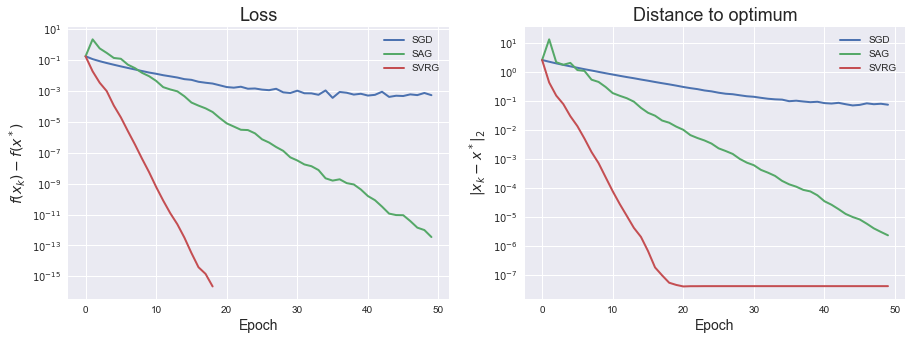

In [270]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 2, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)

plt.legend(solvers);

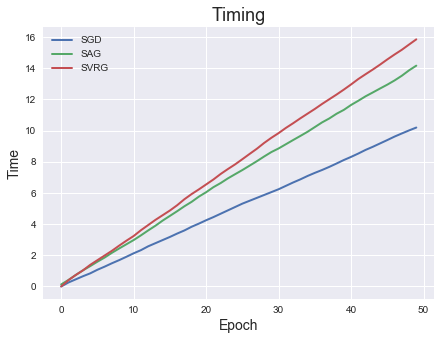

In [271]:
plt.figure(figsize=(7, 5))

plt.subplot(1, 1, 1)

inspectors = [sgd_inspector, sag_inspector, svrg_inspector]

solvers = ["SGD", "SAG", "SVRG"]

for insp in inspectors:
    plt.plot(insp.timing, lw=2)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)

plt.legend(solvers);

<a id='comp'></a> 
## 5. Numerical comparison

# **Log Regression**

### Compare $\lambda = 1/\sqrt{n}$ high and $\lambda = 1/n$ low

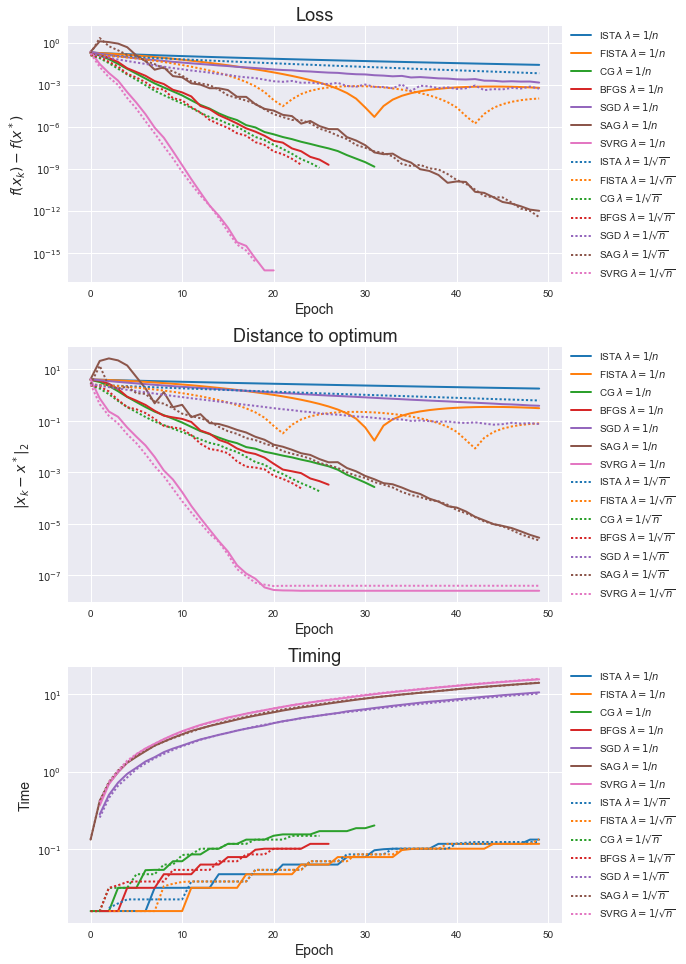

In [272]:
plt.figure(figsize=(8, 13.5))

inspectors_1 = [ista_inspector_l, fista_inspector_l, cg_inspector_l, bfgs_inspector_l,
              sgd_inspector_l, sag_inspector_l, svrg_inspector_l, ista_inspector, 
                 fista_inspector, cg_inspector, bfgs_inspector,
                 sgd_inspector, sag_inspector, svrg_inspector]

solvers_1 = ["ISTA $\lambda=1/n$", "FISTA $\lambda=1/n$", "CG $\lambda=1/n$", "BFGS $\lambda=1/n$", 
           "SGD $\lambda=1/n$", "SAG $\lambda=1/n$", "SVRG $\lambda=1/n$",
           "ISTA $\lambda=1/\sqrt{n}$", "FISTA $\lambda=1/\sqrt{n}$", "CG $\lambda=1/\sqrt{n}$", 
           "BFGS $\lambda=1/\sqrt{n}$", "SGD $\lambda=1/\sqrt{n}$", "SAG $\lambda=1/\sqrt{n}$", "SVRG $\lambda=1/\sqrt{n}$"]

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.subplot(3, 1, 1)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.obj, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 2)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.err, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.subplot(3, 1, 3)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.timing, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.tight_layout()

### Impact of correlations -- logistic regression
### Compare $corr=0.1$ and $corr=0.7$
As we implement all algorithms under high correlation 0.7, now we implement them with low correlation 0.1.

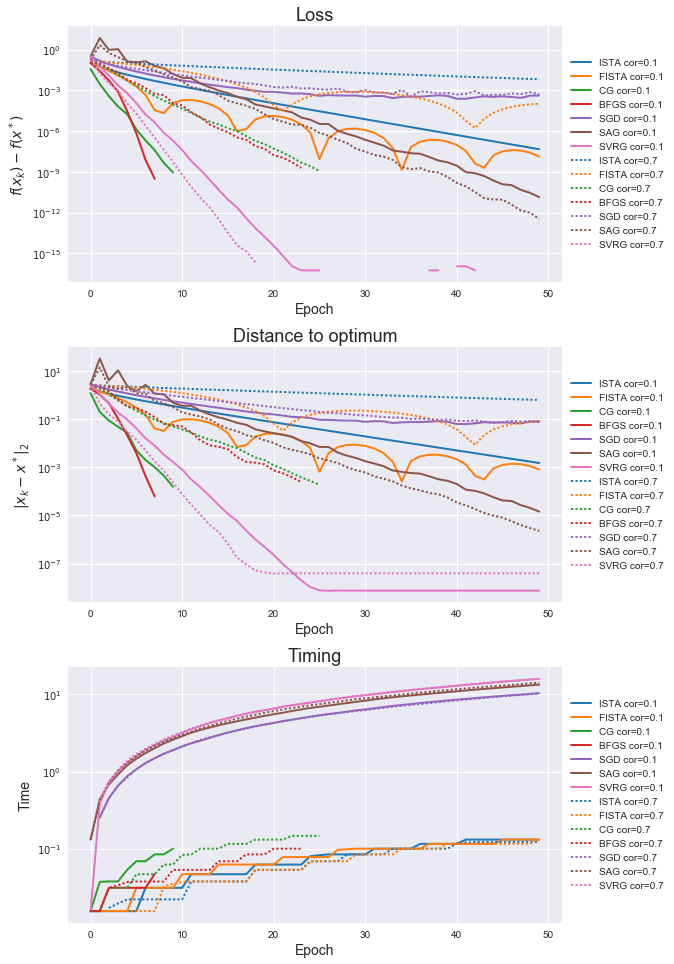

In [273]:
plt.figure(figsize=(8, 13.5))

inspectors_c1 = [ista_inspector_c1, fista_inspector_c1, cg_inspector_c1, bfgs_inspector_c1,
                 sgd_inspector_c1, sag_inspector_c1, svrg_inspector_c1, ista_inspector, 
                 fista_inspector, cg_inspector, bfgs_inspector,
                 sgd_inspector, sag_inspector, svrg_inspector]

solvers_c1 = ["ISTA cor=0.1", "FISTA cor=0.1", "CG cor=0.1", "BFGS cor=0.1", 
           "SGD cor=0.1", "SAG cor=0.1", "SVRG cor=0.1",
           "ISTA cor=0.7", "FISTA cor=0.7", "CG cor=0.7", 
           "BFGS cor=0.7", "SGD cor=0.7", "SAG cor=0.7", "SVRG cor=0.7"]

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.subplot(3, 1, 1)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.obj, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 2)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.err, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.subplot(3, 1, 3)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.timing, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout()

# **Linear Regression**

### compare $\lambda=1/\sqrt{n}$ high and $\lambda = 1/n$ low

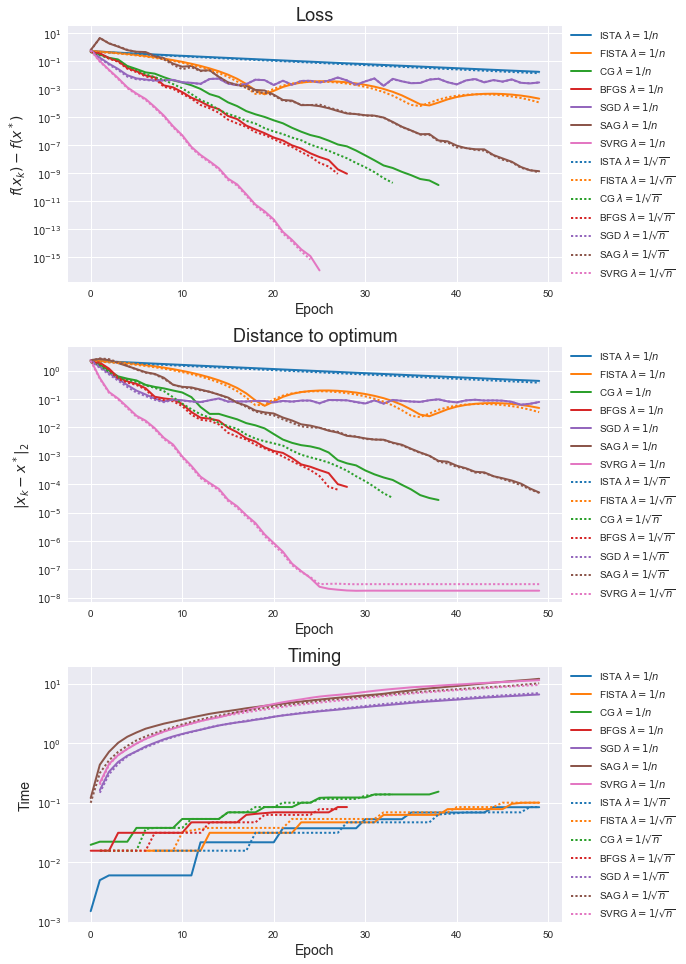

In [229]:
plt.figure(figsize=(8, 13.5))

inspectors_1 = [ista_inspector_l, fista_inspector_l, cg_inspector_l, bfgs_inspector_l,
              sgd_inspector_l, sag_inspector_l, svrg_inspector_l, ista_inspector, 
                 fista_inspector, cg_inspector, bfgs_inspector,
                 sgd_inspector, sag_inspector, svrg_inspector]

solvers_1 = ["ISTA $\lambda=1/n$", "FISTA $\lambda=1/n$", "CG $\lambda=1/n$", "BFGS $\lambda=1/n$", 
           "SGD $\lambda=1/n$", "SAG $\lambda=1/n$", "SVRG $\lambda=1/n$",
           "ISTA $\lambda=1/\sqrt{n}$", "FISTA $\lambda=1/\sqrt{n}$", "CG $\lambda=1/\sqrt{n}$", 
           "BFGS $\lambda=1/\sqrt{n}$", "SGD $\lambda=1/\sqrt{n}$", "SAG $\lambda=1/\sqrt{n}$", "SVRG $\lambda=1/\sqrt{n}$"]

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.subplot(3, 1, 1)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.obj, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 2)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.err, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.subplot(3, 1, 3)

k = 0
line_sty = 'solid' 
for insp in inspectors_1:
    plt.semilogy(insp.timing, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.tight_layout()

### Impact of correlation -- linear regression
### Compare $corr=0.7$ and $corr=0.1$ 

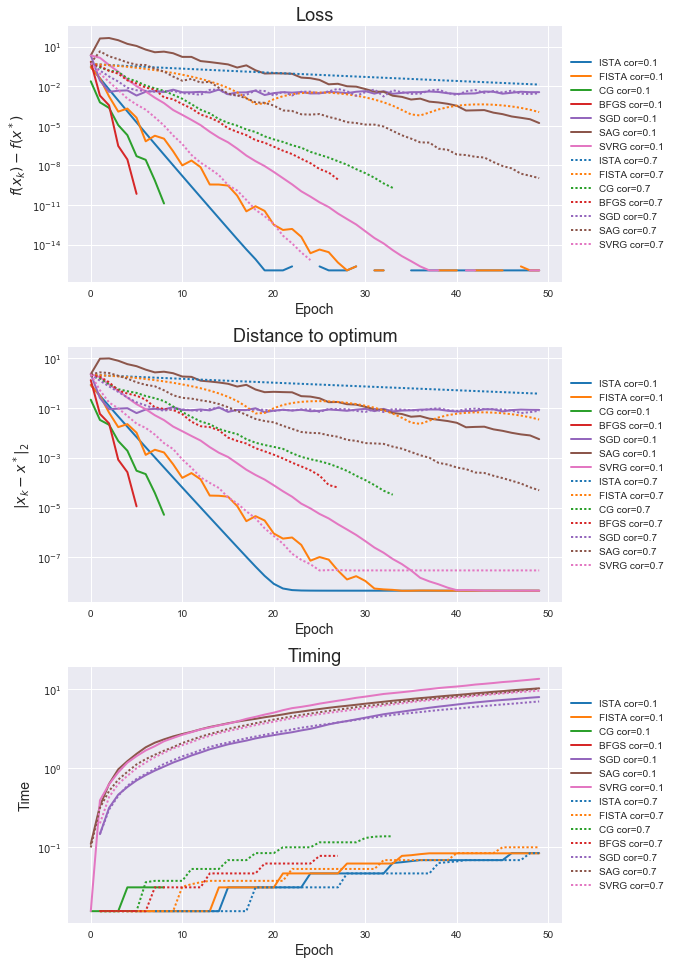

In [230]:
plt.figure(figsize=(8, 13.5))

inspectors_c1 = [ista_inspector_c1, fista_inspector_c1, cg_inspector_c1, bfgs_inspector_c1,
                 sgd_inspector_c1, sag_inspector_c1, svrg_inspector_c1, ista_inspector, 
                 fista_inspector, cg_inspector, bfgs_inspector,
                 sgd_inspector, sag_inspector, svrg_inspector]

solvers_c1 = ["ISTA cor=0.1", "FISTA cor=0.1", "CG cor=0.1", "BFGS cor=0.1", 
           "SGD cor=0.1", "SAG cor=0.1", "SVRG cor=0.1",
           "ISTA cor=0.7", "FISTA cor=0.7", "CG cor=0.7", 
           "BFGS cor=0.7", "SGD cor=0.7", "SAG cor=0.7", "SVRG cor=0.7"]

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

plt.subplot(3, 1, 1)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.obj, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$f(x_k) - f(x^*)$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(3, 1, 2)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.err, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5));

plt.subplot(3, 1, 3)

k = 0
line_sty = 'solid' 
for insp in inspectors_c1:
    plt.semilogy(insp.timing, lw=2, c=color[k], linestyle=line_sty)
    plt.title("Timing", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Time", fontsize=14)
    k += 1
    if k % 7 == 0:
        k = 0
        line_sty = 'dotted'

plt.legend(solvers_c1, loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout()

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- Compare and comment your results
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Conclude

*ANSWERS*:

$Q1$

  - In terms of convergence performance, for the two types of problems, the ranking of all solvers are: $ISTA<SGD<FISTA<SAG<CG<BFGS<SVRG$. During the course, the number of iterations needed for the SVRG or SAG solvers for the convergence $\epsilon$ is $O\left((n+\frac{L_{max}}{\lambda})\log (\frac{1}{\epsilon})\right)$, while the number of iterations needed for gradient descent and $SGD$ are $O\left(\frac{nL}{\lambda}\log (\frac{1}{\epsilon})\right)$ and $O\left(\frac{1}{\lambda\epsilon}\right)$ respectively. As we require a small $\epsilon$ and we have a large $n$, thus the $SGD$, $ISTA$ and $FISTA$ are not as good as other solvers in this problem. On the contrary the $SAG$ and the $SVRG$ solvers have relatively good performance. The $CG$ and $BFGS$ solvers converge in finite iterations and converge faster than all the other methods except the $BFGS$ solver as $BFGS$ is a second order method and that $CG$ is a smart first order method. $BFGS$ is better than $CG$ as it is a second order method. The $SVRG$ method converges faster than the $SAG$ method as it reduces the variance of its solutions during the iterations.

  - In terms of computation time, the order of all the solvers are: $ISTA<FISTA<BFGS<CG<SGD<SVRG<SAG$. The $SVRG$ is more time-consuming than all the other solvers except $SAG$ as for each epoch, it computes $2n$ times the gradient for an observation. Furthermore, in the implementation of $SVRG$, we have two loops and the loops are slow in Python. Although in $SAG$ we do not need to compute two gradients, we have to copy the vectors. Thus this algorithm is slow. $ISTA$ and $FISTA$ are the less time-consuming methods as they only compute $n$ times the gradient for an observation. For each epoch, the second order method $BFGS$ and the conjugate gradient compute the gradient plus some matrix multiplications and thus are more time-consuming than $ISTA$ and $FISTA$. For each epoch, the stochastic methods have at least the cost of computing $n$ times the gradient for an observation and are more time-consuming than $ISTA$ and $FISTA$.
  
$Q2$: Impacts of ridge value $\lambda$

 - For logistic regression, when ridge penalization decreases to $\lambda = 1 / n$, the convergence speeds of all algoritms are slower. Especially for $FISTA$ and $ISTA$, the modification of ridge value impacts the most their convergence speeds than other algorithms. The bounce of $FISTA$ is much longer than under low ridge.  Besides, it is more time-consuming under low ridge for all algorithms. The ranking of convergence performance in low rigde penalization is: $ISTA<SGD<FISTA<SAG<CG<BFGS<SVRG$. The ranking is the same as the high rigde penalization case. 
 
 - For linear regression, all algorithms converge with nearly the same speed with low ridge value except $CG$ and $BFGS$. They converge slower than in the high ridge value case. The computation time is slightly longer with low ridge value. While the aspect different with the logistic regression is that the impact of ridge value is less on linear regression. The ranking of performance in low ridge penalization is the same as in the high ridge penalization case. 
 
**Explanations**

 - Generally, under low ridge condition, that is to say, low penalization, the algorithm should pass through more coefficients to get the minimum loss. Thus the convergence speed is slower. 
 
 - The parameter $\lambda$ indicates the level of strong convexity of the objective. As we have seen in the class, the performances of $SGD$, $ISTA$, $FISTA$ and $SVRG$ are negatively correlated with the level of strong convexity. Thus, the bigger $\lambda$ is, the more slowly those algorithms converge.


$Q3$: Impacts of correlation

 - All **batch methods** converge **faster** in low correlation case than in the high correlation case. The $SGD$ has nearly the same performance in both cases in two types of problems. The other two **stochastic** methods converge **more slowly** in low correlation case.
 
 - For logistic regression, under high correlation case (correlation = 0.7), all algorithms except SAG and SVRG converge more slowly than the low correlation case. $ISTA$ and $FISTA$ are the most sensitive to the change of correlation. The ranking in the low correlation case is: $SGD<ISTA<FISTA<SAG<SVRG<CG<BFGS$. The ranking has changed. 
 
 - For linear regression, in the low correlation case, $ISTA$ performs better than $FISTA$. However, in the high correlation case, $FISTA$ still performs better than $ISTA$. All algorithms perform better in the low correlation case $SGD<SAG<SVRG<FISTA<ISTA<CG<BFGS$. The reponses of $FISTA$ and $ISTA$ to this correlation change are the most intensive. The ranking has thus changed. 
 
**Explanations**

 - Under low correlation, especailly in the linear regression case, the problem becomes more isotopic and the direction to the global minimum is easier to find and thus all algorithms perform better than in the high correlation case. 

 - In low correlation case in linear regression, the direction found by $ISTA$ is close to the globally optimal direction while the one found by $FISTA$ is affected by its past memory. Thus in this case, $ISTA$ performs better than $FISTA$. 
 
 - In high correlation case, the algorithms are implemented in a more singular region and as the distribution of gradient is concentrated, the stochatic methods have more chances to find the optimal direction. However, when the correlation goes down, the region gets more isotopic and the stochastic methods have fewer chances to find the optimal direction. Thus stochastic methods perform better in high correlation cases. 